In [1]:
import datetime
import sys
sys.path.append('/home/s94zalek/shape_matching')

import math
import time
from os import path as osp

import torch.cuda

from datasets import build_dataloader, build_dataset
from datasets.data_sampler import EnlargedSampler

from models import build_model
from utils import (AvgTimer, MessageLogger, get_env_info, get_root_logger,
                   init_tb_logger)
from utils.options import dict2str, parse_options

from train import create_train_val_dataloader

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
import sys
sys.path.append('/home/s94zalek/shape_matching')

import os
os.chdir('/home/s94zalek/shape_matching')

In [4]:
# print current working directory
print(os.getcwd())

/home/s94zalek/shape_matching


In [5]:
import os

# root_path = osp.abspath(osp.join(__file__, osp.pardir))
root_path = '/home/s94zalek/shape_matching'

opt = parse_options(root_path, is_train=False, use_argparse=False)

opt['root_path'] = root_path

# WARNING: should not use get_root_logger in the above codes, including the called functions
# Otherwise the logger will not be properly initialized
log_file = osp.join(opt['path']['log'], f"train_{opt['name']}.log")
logger = get_root_logger(log_file=log_file)
logger.info(get_env_info())
logger.info(dict2str(opt))
# initialize tensorboard logger

# create train and validation dataloaders
result = create_train_val_dataloader(opt, logger)
train_loader, train_sampler, val_loader, total_epochs, total_iters = result

test_set = build_dataset(opt['datasets']['test_dataset'])
test_loader = build_dataloader(
test_set, opt['datasets']['test_dataset'], phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])
#     

# # create test dataset and dataloader
# test_loaders = []
# for _, dataset_opt in sorted(opt['datasets'].items()):
#     test_set = build_dataset(dataset_opt)
#     test_loader = build_dataloader(
#         test_set, dataset_opt, phase='val', num_gpu=opt['num_gpu'], dist=opt['dist'], sampler=None, seed=opt['manual_seed'])
#     logger.info(f"Number of test images in {dataset_opt['name']}: {len(test_set)}")
#     test_loaders.append(test_loader)

Backend DataParallel.
Path already exists. Rename it to /home/s94zalek/shape_matching/results/faust_archived_20240405_171232


2024-04-05 17:12:32,074 INFO: 
Version Information: 
	Python: 3.8.19
	PyTorch: 2.2.2+cu121
	TorchVision: 0.17.2+cu121
2024-04-05 17:12:32,076 INFO: 
  name: faust
  backend: dp
  type: FMNetModel
  num_gpu: 1
  manual_seed: 1234
  non-isometric: False
  partial: False
  path:[
    resume_state: None
    results_root: /home/s94zalek/shape_matching/results/faust
    log: /home/s94zalek/shape_matching/results/faust/log
    visualization: /home/s94zalek/shape_matching/results/faust/visualization
  ]
  datasets:[
    train_dataset:[
      name: FaustTrain
      type: PairFaustDataset
      phase: train
      data_root: data/FAUST_r
      return_evecs: True
      return_faces: True
      num_evecs: 200
      return_corr: False
      return_dist: False
    ]
    test_dataset:[
      name: FaustTest
      type: PairFaustDataset
      phase: test
      data_root: data/FAUST_r
      return_evecs: True
      return_faces: True
      num_evecs: 200
      return_corr: True
      return_dist: True
 

In [6]:
train_dataset = train_loader.dataset

In [7]:
for key in train_dataset[10]['first'].keys():
    print(key)
    if key == 'name':
        print(train_dataset[10]['first'][key], train_dataset[10]['second'][key])
        # print('')
        continue
    
    print(train_dataset[10]['first'][key].shape, train_dataset[10]['second'][key].shape)
    # print('')
    
# print(train_dataset[10]['first']['mass'].shape)

name
tr_reg_000 tr_reg_010
verts
torch.Size([4999, 3]) torch.Size([5000, 3])
faces
torch.Size([9994, 3]) torch.Size([9996, 3])
evecs
torch.Size([4999, 200]) torch.Size([5000, 200])
evecs_trans
torch.Size([200, 4999]) torch.Size([200, 5000])
evals
torch.Size([200]) torch.Size([200])
mass
torch.Size([4999]) torch.Size([5000])
L
torch.Size([4999, 4999]) torch.Size([5000, 5000])


# Distance matrices

In [8]:
# open /home/s94zalek/shape_matching/data/FAUST_r/dist/tr_reg_001.mat with scipy.io.loadmat
import scipy.io
import numpy as np
import os

# load the data
data = scipy.io.loadmat('/home/s94zalek/shape_matching/data/FAUST_r/dist/tr_reg_001.mat')


In [9]:
print(data['dist'])

[[0.         0.02143635 0.04757253 ... 0.61128948 0.66526834 0.38543646]
 [0.02143635 0.         0.06101074 ... 0.61200583 0.65902633 0.38615281]
 [0.04757253 0.06101074 0.         ... 0.5714207  0.64763514 0.34556768]
 ...
 [0.61128948 0.61200583 0.5714207  ... 0.         0.32518163 0.22585302]
 [0.66526834 0.65902633 0.64763514 ... 0.32518163 0.         0.35613404]
 [0.38543646 0.38615281 0.34556768 ... 0.22585302 0.35613404 0.        ]]


In [10]:
# save data['dist'] to /home/s94zalek/shape_matching/output
np.save('/home/s94zalek/shape_matching/output/dist.npy', data['dist'])

# save train_dataset[10]['first']['L']
np.save('/home/s94zalek/shape_matching/output/L.npy', train_dataset[10]['first']['L'])

# Plot the shapes

In [11]:
print(list(train_dataset[10]['first'].keys()))

['name', 'verts', 'faces', 'evecs', 'evecs_trans', 'evals', 'mass', 'L']


In [12]:
import trimesh

# plot first and second shapes
shape_1 = trimesh.Trimesh(vertices=train_dataset[10]['first']['verts'], faces=train_dataset[10]['first']['faces'])
shape_2 = trimesh.Trimesh(vertices=train_dataset[10]['second']['verts'] + np.array([1, 0, 0]), faces=train_dataset[10]['second']['faces'])

# show both shapes in a scene
scene = trimesh.Scene([shape_1, shape_2])
scene.show()



# Test dataset

In [13]:
print(list(test_set[10]['first'].keys()))

['name', 'verts', 'faces', 'evecs', 'evecs_trans', 'evals', 'mass', 'L', 'dist', 'corr']


In [14]:
for key in test_set[10]['first'].keys():
    print(key)
    if key == 'name':
        print(test_set[10]['first'][key], test_set[10]['second'][key])
        # print('')
        continue
    
    print(test_set[10]['first'][key].shape, test_set[10]['second'][key].shape)

name
tr_reg_080 tr_reg_090
verts
torch.Size([5000, 3]) torch.Size([5000, 3])
faces
torch.Size([9996, 3]) torch.Size([9996, 3])
evecs
torch.Size([5000, 200]) torch.Size([5000, 200])
evecs_trans
torch.Size([200, 5000]) torch.Size([200, 5000])
evals
torch.Size([200]) torch.Size([200])
mass
torch.Size([5000]) torch.Size([5000])
L
torch.Size([5000, 5000]) torch.Size([5000, 5000])
dist
torch.Size([5000, 5000]) torch.Size([5000, 5000])
corr
torch.Size([5000]) torch.Size([5000])


In [79]:
data_x = test_set[15]['first']
data_y = test_set[15]['second']

evecs_x = data_x['evecs'].squeeze()
evecs_y = data_y['evecs'].squeeze()
evecs_trans_x = data_x['evecs_trans'].squeeze()
evecs_trans_y = data_y['evecs_trans'].squeeze()

In [16]:
print(data_x['corr'].shape, data_y['corr'].shape)
print(data_x['corr'].min(), data_x['corr'].max(), len(data_x['corr'].unique()))

torch.Size([5000]) torch.Size([5000])
tensor(0) tensor(4999) 3462


# Meaning of correspondence and p2p matrices

In [105]:
corr_x = np.array([5, 10, 15]) # P_xGT
# corr_x = np.array([0, 1, 2]) # P_xGT
# vertex 0 of x corresponds to vertex 0 of reference
# vertex 1 of x corresponds to vertex 1 of reference
# vertex 2 of x corresponds to vertex 2 of reference

corr_y = np.array([10, 15, 5]) # P_yGT
# corr_y = np.array([1, 2, 0]) # P_yGT
# vertex 0 of y corresponds to vertex 1 of reference
# vertex 1 of y corresponds to vertex 2 of reference
# vertex 2 of y corresponds to vertex 0 of reference

p2p = np.array([2, 0, 1]) # P_xy
# vertex 0 of x corresponds to vertex 2 of y
# vertex 1 of x corresponds to vertex 0 of y
# vertex 2 of x corresponds to vertex 1 of y


###################################
# ATTENTION!!!
###################################

# P_xy is called "shape y -> shape x"

dist_x = np.array(
    [[0, 6, 7],
    [6, 0, 8],
    [7, 8, 0]]
    )

print('p2p[corr_y], or P_xy @ P_yGT:', p2p[corr_y])
ind21 = np.stack([corr_x, p2p[corr_y]], axis=-1)
print('after stack:', ind21)
ind21 = np.ravel_multi_index(ind21.T, dims=[dist_x.shape[0], dist_x.shape[0]])
print('after ravel', ind21)
geo_err = np.take(dist_x, ind21)
print('geo_err', geo_err, '\n')

print('checking that corr_x = p2p @ corr_y \n',
 'P_xGT = P_xy @ P_yGT')
np.eye(3) == np.array([[0,0,1], [1,0,0], [0,1,0]]) @ np.array([[0,1,0], [0,0,1], [1,0,0]])
# corr_x = p2p @ corr_y
# P_xGT = P_xy @ P_yGT

IndexError: index 10 is out of bounds for axis 0 with size 3

In [ ]:
# # get inverse correspondences
# P_GTx = np.argsort(corr_x)
# P_GTy = np.argsort(corr_y)
# P_xy = p2p
# P_yx = np.argsort(P_xy)

# # test conversion of permutation indices to permutation matrices
# P_GTx_mat = perm2mat(P_GTx)
# P_GTy_mat = perm2mat(P_GTy)

# print('P_GTy\n', P_GTy)
# print('P_GTy_mat\n', P_GTy_mat)
# print('mat2perm(P_GTy_mat)\n', mat2perm(P_GTy_mat))

In [104]:
# count how many times each element in data_x['corr'] appears and sort by the number of appearances
print(np.unique(data_x['corr'], return_counts=True))
print(np.unique(data_y['corr'], return_counts=True))

(array([   0,    1,    2, ..., 4993, 4998, 4999]), array([1, 4, 1, ..., 1, 1, 1]))
(array([   0,    1,    2, ..., 4995, 4997, 4999]), array([1, 3, 2, ..., 4, 1, 1]))


In [117]:
# convert permutation indices to permutation matrices
def perm2mat(perm, dim0):

    n = len(perm)
    mat = torch.zeros(dim0, n)
    mat[perm, torch.arange(n)] = 1
    return mat

def mat2perm(mat):
    return mat.nonzero()

def get_Pxy_from_PxGT_PyGT(P_xGT, P_yGT):
    # P_GTx = torch.argsort(P_xGT)
    # P_GTy = torch.argsort(P_yGT)

    P_xGT_mat = perm2mat(P_xGT, len(data_x['verts']))
    P_yGT_mat = perm2mat(P_yGT, len(data_y['verts']))
    
    # wrong
    # P_GTx_mat = P_xGT_mat.T
    # P_GTy_mat = P_yGT_mat.T
    
    # assert torch.allclose(P_GTx_mat @ P_xGT_mat, torch.eye(len(data_x['verts'])))
    # assert torch.allclose(P_GTy_mat @ P_yGT_mat, torch.eye(len(data_y['verts'])))
    
    # print(P_GTx_mat, torch.linalg.pinv(P_xGT_mat.cuda()).cpu())
    
    # assert torch.allclose(P_GTx_mat, torch.linalg.pinv(P_xGT_mat.cuda()).cpu().round())
    # assert torch.allclose(P_GTy_mat, torch.linalg.pinv(P_yGT_mat.cuda()).cpu().round())
    
    # P_GTx_mat = perm2mat(P_GTx)
    # P_GTy_mat = perm2mat(P_GTy)
    
    P_xy_mat = P_xGT_mat @ P_GTy_mat
    
    # P_xy_mat = torch.linalg.lstsq(
    #     P_GTx_mat.to('cuda'),
    #     P_GTy_mat.to('cuda')
    #     ).solution.cpu()
    
    # assert that the solution sums correctly
    # assert torch.allclose(torch.sum(P_xy_mat, axis=-1), torch.tensor(1.))
    
    #########################
    # Verify the solution
    #########################

    # assert that all elements are true P_xy_mat @ P_yGT_mat == P_xGT_mat
    # assert torch.allclose(P_xy_mat @ P_yGT_mat, P_xGT_mat)
    # which elements are not equal?
    # print((P_xy_mat @ P_yGT_mat).sum(), P_xGT_mat.sum())
    # print((P_xy_mat @ P_yGT_mat != P_xGT_mat).sum())
    # print(torch.where(P_xy_mat @ P_yGT_mat != P_xGT_mat))


    lhs = P_xy_mat @ P_yGT_mat
    rhs = P_xGT_mat
    
    correct = 0
    wrong = 0
    for i in range(lhs.shape[0]):
        # indices where the value of lhs[i] is not equal to rhs[i]
        
        lhs_nonzero = (lhs[i] == 1).nonzero().sort().values
        rhs_nonzero = (rhs[i] == 1).nonzero().sort().values
        
        # if lhs_nonzero is an empty tensor
        if len(lhs_nonzero) == 0:
            continue
        elif len(lhs_nonzero) != len(rhs_nonzero):
            print(lhs_nonzero, rhs_nonzero)
            wrong += 1
        elif torch.all(lhs_nonzero == rhs_nonzero):
                correct += 1
        else:
            wrong += 1
            
    print('correct:', correct, 'wrong:', wrong, 'total:', lhs.shape[0])
    return mat2perm(P_xy_mat)


a = get_Pxy_from_PxGT_PyGT(data_x['corr'], data_y['corr'])
a
# print(data_x['corr'], data_y['corr'])


AssertionError: 

In [103]:
data_x['name'], data_y['name']

('tr_reg_080', 'tr_reg_095')

In [25]:
# test solving for P_xy
print('P_xy', P_xy)
print('Solution', mat2perm(np.linalg.lstsq(P_GTx_mat, P_GTy_mat)[0]))

P_xy [2 0 1]
Solution [2 0 1]


In [27]:
get_Pxy_from_PxGT_PyGT(corr_x, corr_y)

array([2, 0, 1])

In [54]:
P_xy = get_Pxy_from_PxGT_PyGT(data_x['corr'], data_y['corr'])
P_yx = torch.argsort(P_xy)

P_xy_mat = perm2mat(P_xy)
P_yx_mat = perm2mat(P_yx)
print(P_xy_mat.sum(), P_yx_mat.sum())

print(data_y['evecs_trans'].dtype)
C_xy = data_y['evecs_trans'].squeeze() @ P_yx_mat @ data_x['evecs'].squeeze()
print(C_xy.shape)
print(C_xy)

tensor(5000.) tensor(5000.)
torch.float32
torch.Size([200, 200])
tensor([[-1.0000e+00, -1.6956e-01, -2.4349e-02,  ..., -6.0468e-02,
          6.4883e-03, -1.7703e-02],
        [-1.4803e-06, -5.5290e-02,  3.4969e-02,  ..., -2.8798e-02,
          1.0013e-02,  6.4887e-03],
        [ 4.9360e-08, -9.1790e-03,  5.8620e-02,  ...,  2.5183e-02,
         -2.2349e-02,  7.7939e-04],
        ...,
        [-5.2969e-08,  3.3756e-02,  1.1634e-02,  ..., -3.0465e-02,
          1.0235e-02, -4.8726e-03],
        [-3.1665e-08,  2.7796e-03,  2.4197e-02,  ..., -2.5798e-02,
          6.9133e-03,  1.5584e-03],
        [-1.7695e-08, -3.0271e-03, -5.5073e-03,  ...,  1.5893e-02,
          3.0179e-02,  5.1060e-03]])


In [75]:
P_xGT_mat = perm2mat(data_x['corr'])
P_yGT_mat = perm2mat(data_y['corr'])

# assert that all elements are true P_xy_mat @ P_yGT_mat == P_xGT_mat
# assert torch.allclose(P_xy_mat @ P_yGT_mat, P_xGT_mat)
# which elements are not equal?
print((P_xy_mat @ P_yGT_mat).sum(), P_xGT_mat.sum())
print((P_xy_mat @ P_yGT_mat != P_xGT_mat).sum())
print(torch.where(P_xy_mat @ P_yGT_mat != P_xGT_mat))

for i in range(5):
    print(
        torch.argmax((P_yx_mat @ P_xGT_mat)[i]),
        torch.argmax(P_yGT_mat[i])
        )
        

tensor(5000.) tensor(5000.)
tensor(9894)
(tensor([   0,    0,    1,  ..., 4997, 4999, 4999]), tensor([4402, 4433, 1124,  ..., 3655, 2467, 2537]))
tensor(4392) tensor(4357)
tensor(1179) tensor(1129)
tensor(1939) tensor(1912)
tensor(3683) tensor(3650)
tensor(1826) tensor(1762)


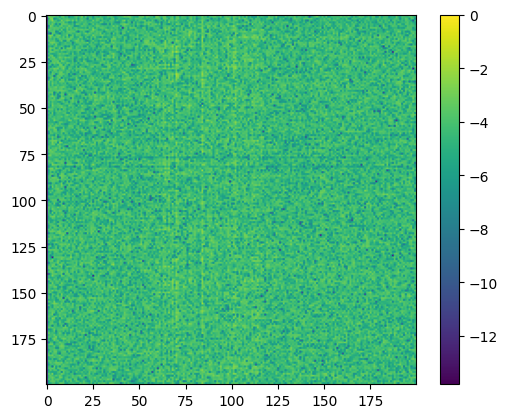

In [58]:
# plot matrix C_xy
import matplotlib.pyplot as plt
plt.imshow(torch.log(torch.abs(C_xy) + 1e-6))
# use log scale

plt.colorbar()
plt.show()


In [107]:
!python preprocess.py --data_root data/SHREC16_test/holes --no_normalize --n_eig 200

 14%|█████▉                                    | 28/200 [06:07<24:19,  8.48s/it]